Number of unique categories: 24
Number of unique web services: 141
Number of unique links: 2344392


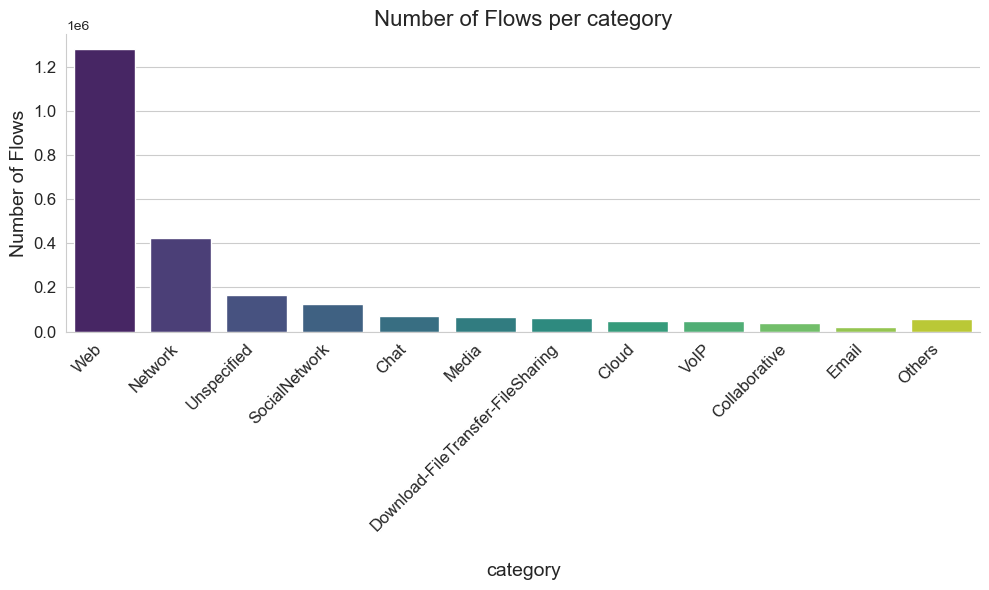

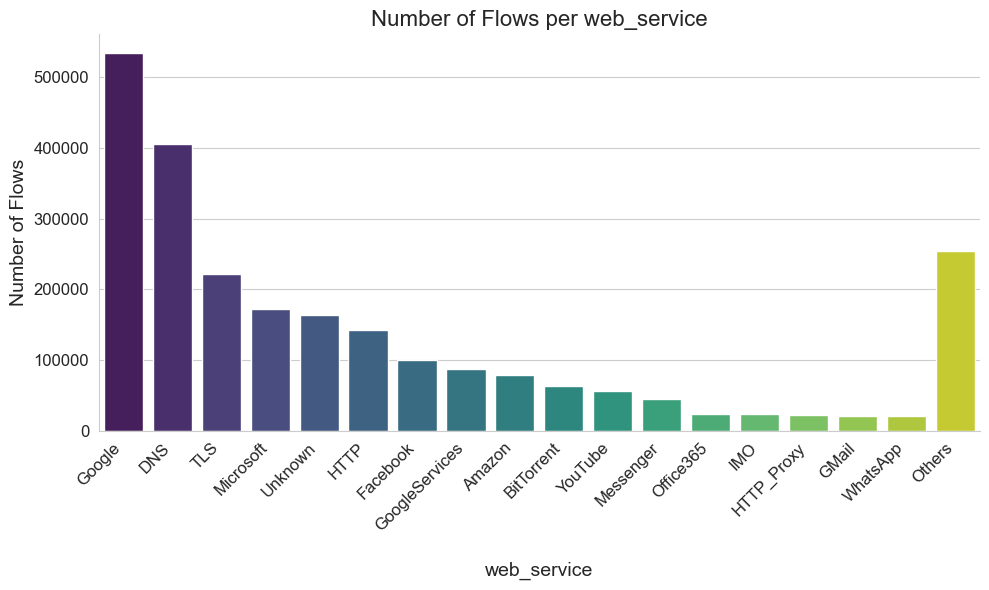

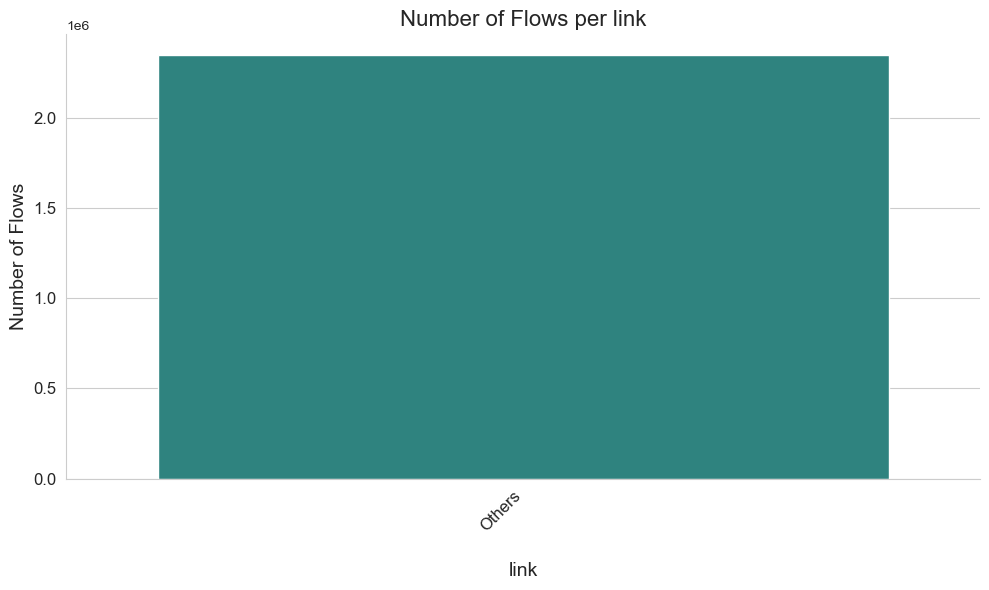

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "../../web_service_dataset.csv"
df = pd.read_csv(file_path)

# 1.1
unique_categories = df['category'].nunique()
unique_web_services = df['web_service'].nunique()

df['link'] = df['src_ip'] + ' -> ' + df['dst_ip']  + ':' + df['src_port'].astype(str) + ':' + df['dst_port'].astype(str)
unique_links = df['link'].nunique()

print(f"Number of unique categories: {unique_categories}")
print(f"Number of unique web services: {unique_web_services}")
print(f"Number of unique links: {unique_links}")

df_categories = ['category', 'web_service', 'link']
df_threshold = [20000, 20000, 500]

# For each of the three entities, draw a bar plot indicating the number of flows belong to a class
# for a certain entity. If there are some targets (e.g., a certain web service) that have
# too few samples, group them as “others”

for index, elem in enumerate(df_categories):
    flow_by_elem = df.groupby(elem)['flow_key'].nunique().sort_values(ascending=False)
    small_values = flow_by_elem[flow_by_elem < df_threshold[index]].sum()
    flow_by_elem = flow_by_elem[flow_by_elem >= df_threshold[index]]
    
    if small_values > 0:
        flow_by_elem["Others"] = small_values
    
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=flow_by_elem.index, y=flow_by_elem.values, hue=flow_by_elem.index, palette='viridis', legend=False) 
    plt.title(f'Number of Flows per {elem}', fontsize=16)
    plt.xlabel(f'{elem}', fontsize=14, labelpad=20)
    plt.ylabel("Number of Flows", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.tight_layout()
    plt.show()


In [242]:
# 1.2
from sklearn.preprocessing import LabelEncoder

# How many unique protocols are there in the dataset?
unique_proto = df['proto'].unique()
    
print(f"Number of unique proto: {len(unique_proto)}")

# Convert such a categorical feature into a numerical one through one-hot encoding.
one_hot_proto = pd.get_dummies(df['proto'], prefix='proto')

# Convert string labels (category and web service) into numerical classes.

label_encoder_category = LabelEncoder()
label_encoder_service = LabelEncoder()
category_numerical_class = label_encoder_category.fit_transform(df['category'])
web_service_numerical_class = label_encoder_service.fit_transform(df['web_service'])

print(category_numerical_class)
print(web_service_numerical_class)

Number of unique proto: 3
[11 11 11 ... 18 23 23]
[17 17 17 ... 64 31 31]


In [243]:
# 1.3

# Do you find features that only have a constant value?

numeric_df = df.select_dtypes(include=['number']) 
constant_features = [col for col in numeric_df if numeric_df[col].std() == 0]

print(f"Constant features: {constant_features}")

if len(constant_features) > 0:
    df = df.drop(columns=constant_features)
    
# Do you find features that have low variance? If yes, do you think whether we should remove them or not?

numeric_var = numeric_df.var().mean()

numeric_std = numeric_df.std().mean()

print(f"Average Variance: {numeric_var}")

print(f"Average Standard deviation: {numeric_std}")

low_var = 0.000001 * numeric_var

low_variance_features = [col for col in numeric_df if numeric_df[col].var() < low_var]

high_variance_features = [col for col in numeric_df if numeric_df[col].var() > low_var]

num_of_low_variance = len(low_variance_features)

num_of_high_variance = len(high_variance_features)

print(f"Low variance features: {num_of_low_variance}")

print(f"High variance features: {num_of_high_variance}")

# With low variance we couldn't understand if information of this object will be significant for the training


Constant features: []
Average Variance: 2.728525993029358e+22
Average Standard deviation: 35242034569.43971
Low variance features: 40
High variance features: 4


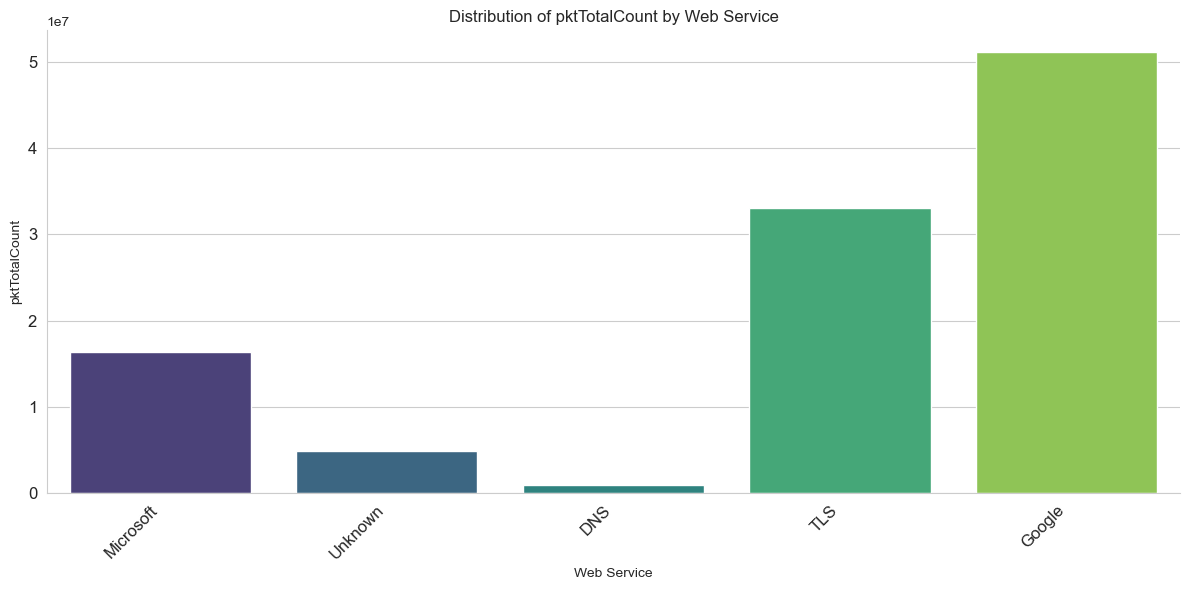

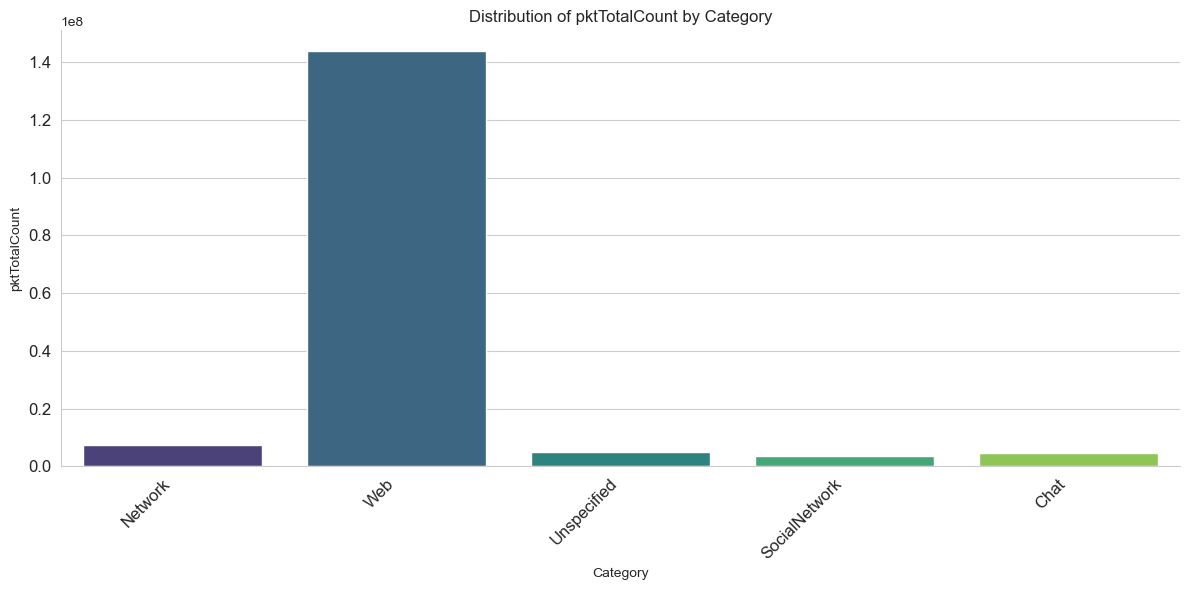

In [244]:
# 1.4

# Step 1: Check the frequency of 'web_service' and 'category' values
service_counts = df['web_service'].value_counts()
category_counts = df['category'].value_counts()

# Select the top 5 services and categories with sufficient samples
top_services = service_counts.head(5).index
top_categories = category_counts.head(5).index

# Step 2: Choose a feature for visualization (e.g., 'pktTotalCount')
feature = 'pktTotalCount'

# Filter the dataset for the selected services and categories
service_data = df[df['web_service'].isin(top_services)]
category_data = df[df['category'].isin(top_categories)]

# Distribution of features by Web Service
plt.figure(figsize=(12, 6))
sns.barplot(
    data=service_data,
    x='web_service',
    y=feature,
    hue='web_service',  # Assign the x variable to hue
    palette='viridis',
    estimator=sum,  # Aggregate values for each category
    errorbar=None,  # Disable confidence intervals
    dodge=False  # Prevent bars from being split
)
plt.title(f"Distribution of {feature} by Web Service")
plt.xlabel("Web Service")
plt.ylabel(feature)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()

# Distribution of features by Category
plt.figure(figsize=(12, 6))
sns.barplot(
    data=category_data,
    x='category',
    y=feature,
    hue='category',  # Assign the x variable to hue
    palette='viridis',
    estimator=sum,  # Aggregate values for each category
    errorbar=None,  # Disable confidence intervals
    dodge=False  # Prevent bars from being split
)
plt.title(f"Distribution of {feature} by Category")
plt.xlabel("Category")
plt.ylabel(feature)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


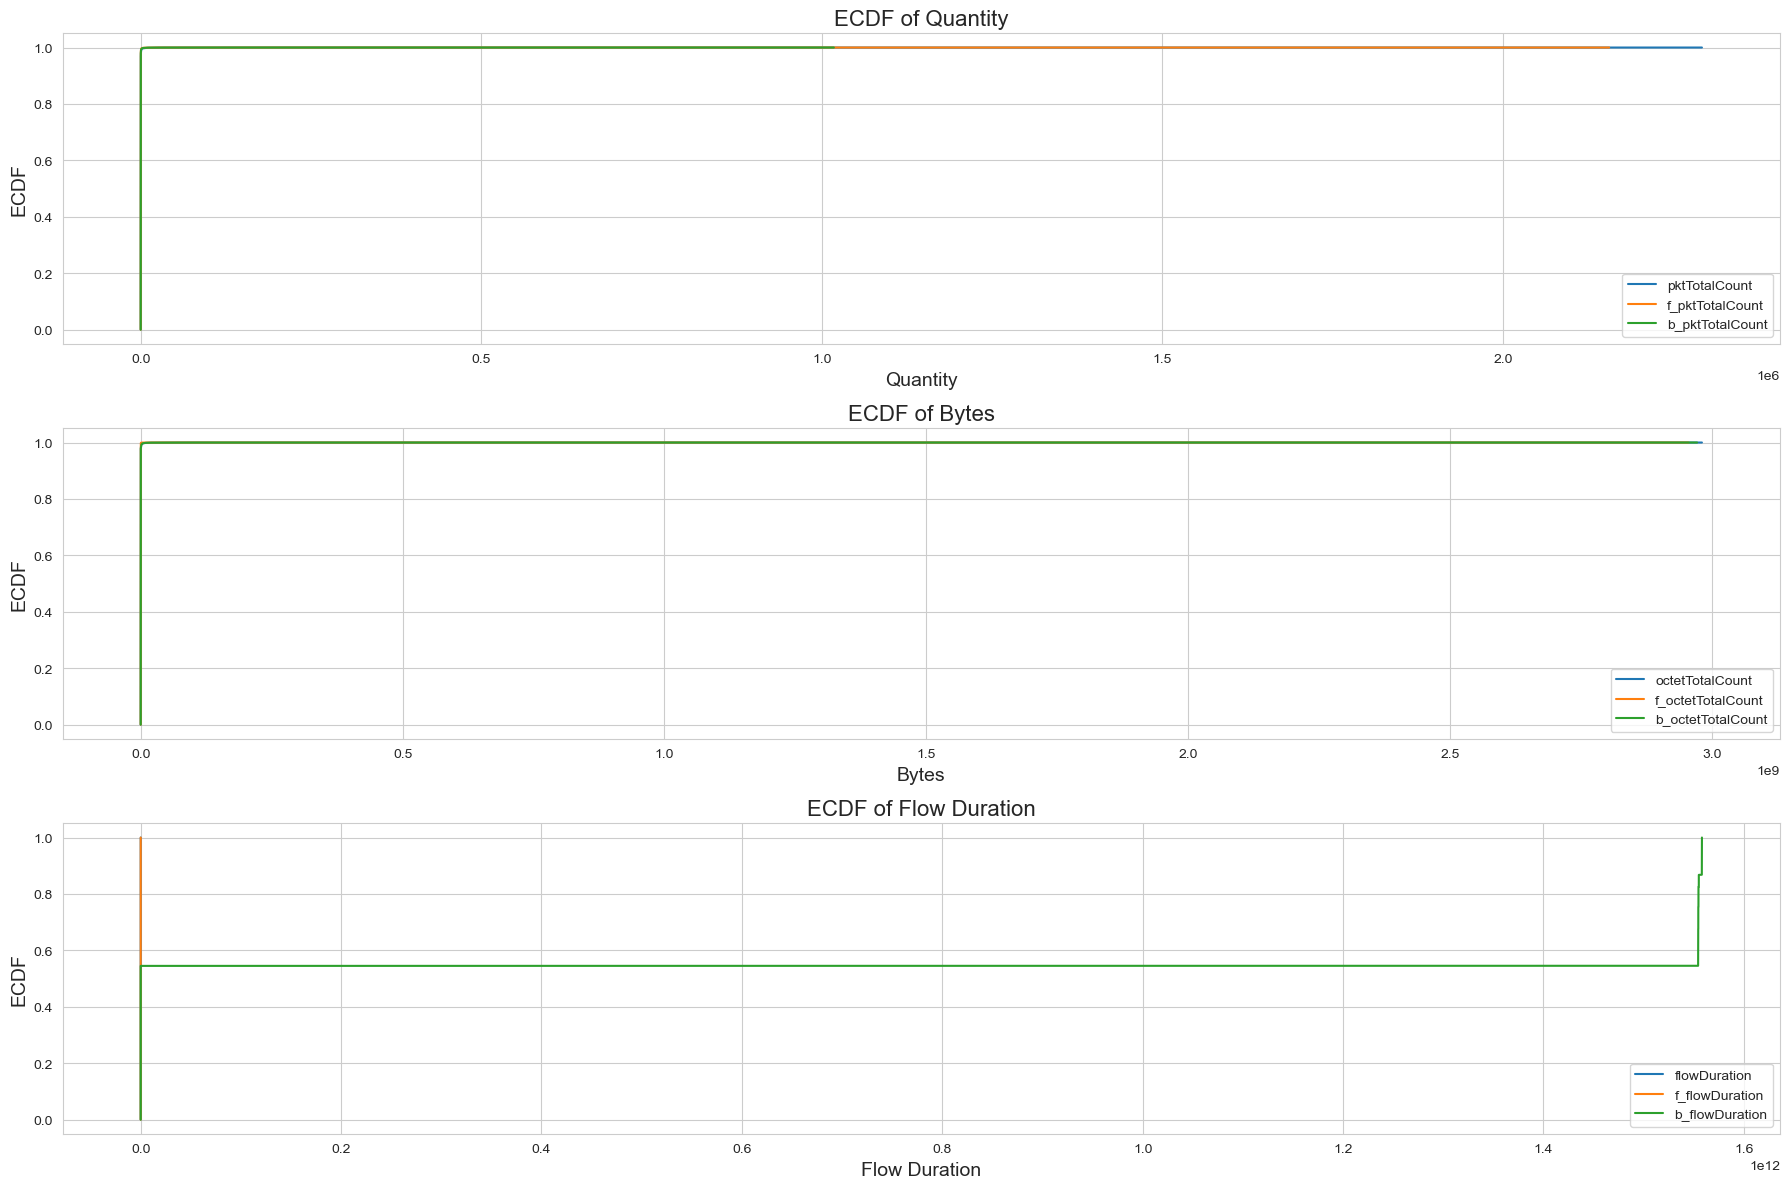

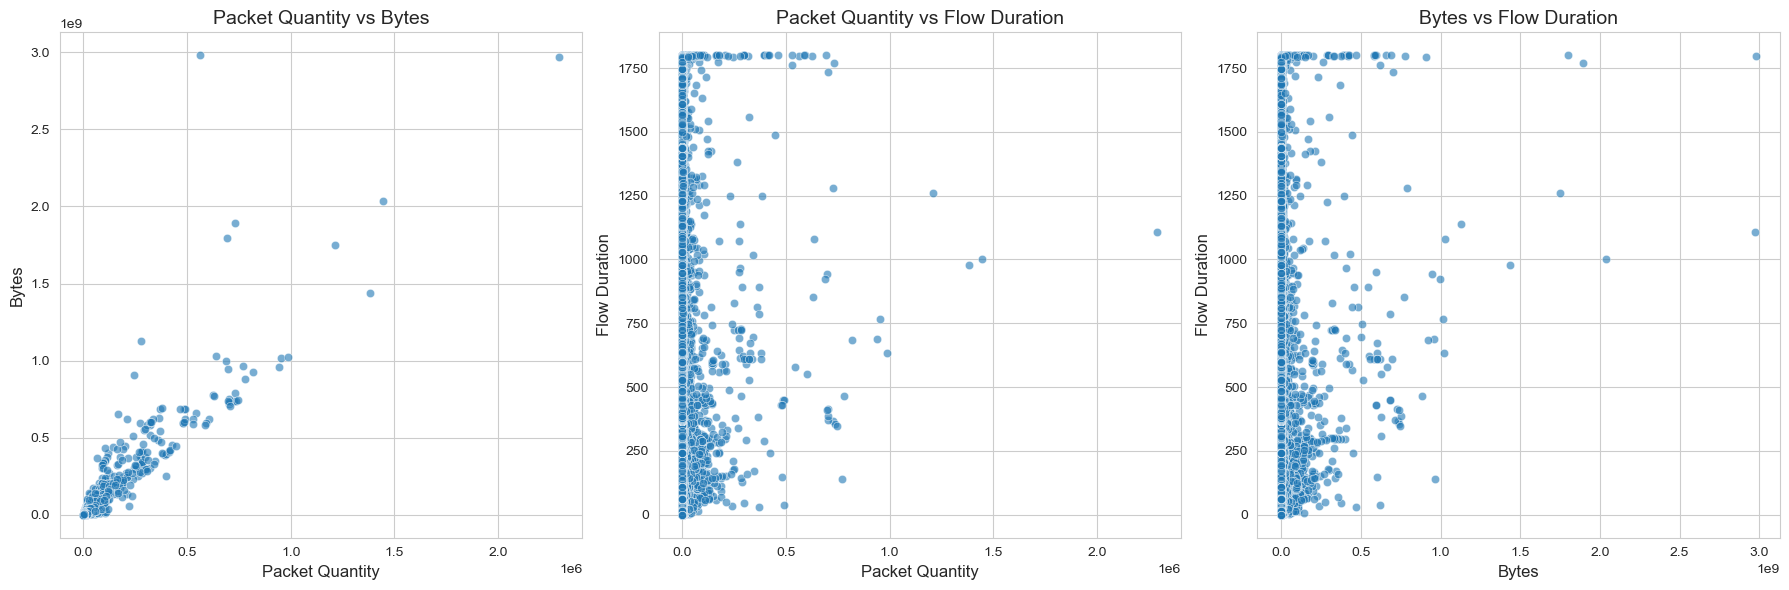

(                 pktTotalCount  octetTotalCount  flowDuration
 pktTotalCount         1.000000         0.922037      0.049610
 octetTotalCount       0.922037         1.000000      0.041326
 flowDuration          0.049610         0.041326      1.000000,
 1027.47900875569)

In [245]:
# ECDF function
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

# Features for analysis
features = {
    "Quantity": ['pktTotalCount', 'f_pktTotalCount', 'b_pktTotalCount'],
    "Bytes": ['octetTotalCount', 'f_octetTotalCount', 'b_octetTotalCount'],
    "Flow Duration": ['flowDuration', 'f_flowDuration', 'b_flowDuration']
}

# Step 1: ECDF plots
plt.figure(figsize=(18, 12))
for i, (feature_group, columns) in enumerate(features.items(), start=1):
    plt.subplot(3, 1, i)
    for col in columns:
        x, y = ecdf(df[col].dropna())  # Drop NaN values to avoid errors
        plt.plot(x, y, label=col)
    plt.title(f"ECDF of {feature_group}", fontsize=16)
    plt.xlabel(feature_group, fontsize=14)
    plt.ylabel("ECDF", fontsize=14)
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# Step 2: Identify outliers in flow duration
flow_duration = df['flowDuration'].dropna()
x_flow, y_flow = ecdf(flow_duration)
outlier_threshold = np.percentile(flow_duration, 99)  # Top 1% as potential outliers

# Step 3: Correlation analysis
correlation_matrix = df[
    ['pktTotalCount', 'octetTotalCount', 'flowDuration']
].corr()

# Scatter plots for visual inspection
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='pktTotalCount', y='octetTotalCount', alpha=0.6)
plt.title("Packet Quantity vs Bytes", fontsize=14)
plt.xlabel("Packet Quantity", fontsize=12)
plt.ylabel("Bytes", fontsize=12)
plt.grid(True)

plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='pktTotalCount', y='flowDuration', alpha=0.6)
plt.title("Packet Quantity vs Flow Duration", fontsize=14)
plt.xlabel("Packet Quantity", fontsize=12)
plt.ylabel("Flow Duration", fontsize=12)
plt.grid(True)

plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x='octetTotalCount', y='flowDuration', alpha=0.6)
plt.title("Bytes vs Flow Duration", fontsize=14)
plt.xlabel("Bytes", fontsize=12)
plt.ylabel("Flow Duration", fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

correlation_matrix, outlier_threshold
